### Libraries, functions etc.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.special import expit

import sys
sys.path.insert(1, '../')

import measures
from model import LogReg
from preprocessing import Preprocessor
import experiments

### Loading data

In [3]:
wdbc_df=pd.read_csv('../data/wdbc.csv')

y_wdbc=wdbc_df['diagnosis']=="M"
X_wdbc=wdbc_df.drop(columns=["id","diagnosis","Unnamed: 32"])

prep_wdbc = Preprocessor()

In [4]:
X_wdbc_train, X_wdbc_test, y_wdbc_train, y_wdbc_test = prep_wdbc.train_test_split(X_wdbc, y_wdbc)

Dataset basic info:

In [6]:
X_wdbc_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 426 entries, 321 to 289
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   radius_mean              426 non-null    float64
 1   texture_mean             426 non-null    float64
 2   perimeter_mean           426 non-null    float64
 3   area_mean                426 non-null    float64
 4   smoothness_mean          426 non-null    float64
 5   compactness_mean         426 non-null    float64
 6   concavity_mean           426 non-null    float64
 7   concave points_mean      426 non-null    float64
 8   symmetry_mean            426 non-null    float64
 9   fractal_dimension_mean   426 non-null    float64
 10  radius_se                426 non-null    float64
 11  texture_se               426 non-null    float64
 12  perimeter_se             426 non-null    float64
 13  area_se                  426 non-null    float64
 14  smoothness_se           

No missing values, all variables are numeric, so one-hot encoding is not needed. Not so many observations, only 426 in the training dataset.

In [11]:
y_wdbc_train.mean()

0.3732394366197183

The dataset is fairly balanced, 37% of observations are positive. Please note that train and test subsets have the same ratios of classes.

In [8]:
X_train=X_wdbc_train.copy()
X_test=X_wdbc_test.copy()
y_train=y_wdbc_train.copy()
y_test=y_wdbc_test.copy()

#Collinearity removal
X_train = prep_wdbc.remove_multicollinearity_fit_transform(X_train)
X_test = prep_wdbc.remove_multicollinearity_transform(X_test)


X_train=X_train.to_numpy()
y_train=y_train.to_numpy()
X_test=X_test.to_numpy()
y_test=y_test.to_numpy()

7 numerical features left in dataset  0  categorical


#### 1. Convergence analysis: check how the value of log-likelihood function depends on the number of iterations for 4 above algorithms.

In [9]:
lr=0.01
n_epochs=1000

lr_models = {
     'GD': LogReg(optimization='Gradient Descent', learning_rate=lr, epochs=n_epochs, batch_size=0.1),
     'SGD': LogReg(optimization='Stochastic Gradient Descent', learning_rate=lr, epochs=n_epochs),
     'IRLS': LogReg(optimization='Iterative Reweighted Least Squares', epochs=n_epochs),
     'ADAM': LogReg(optimization='Adaptive Moment Estimation', epochs=n_epochs, learning_rate=0.01, beta_1=0.9,
                    beta_2=0.99, epsilon=1e-8)
 }

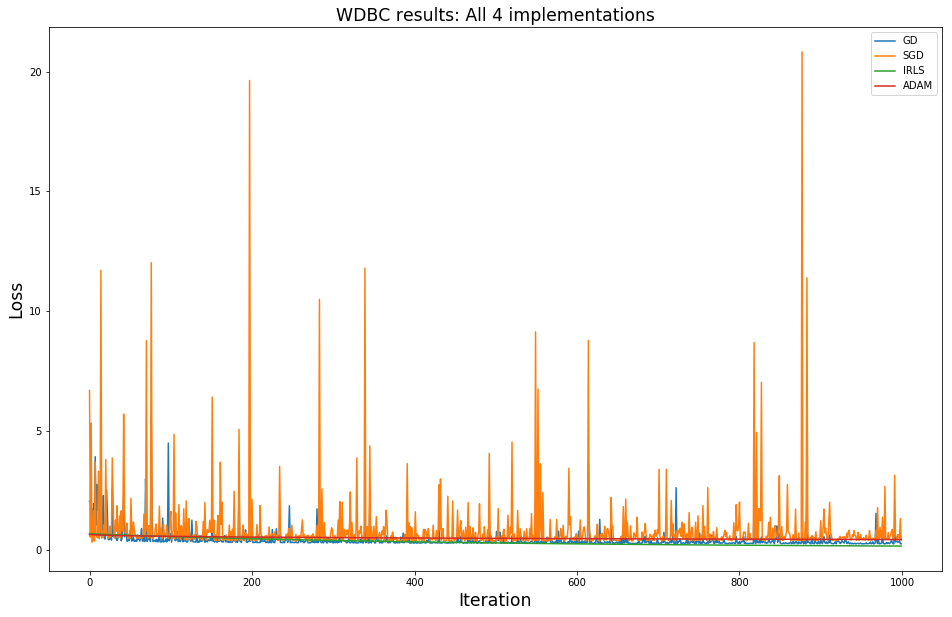

In [37]:
plt.figure(figsize=(16, 10))
losses={}
for model_name, model in lr_models.items():
    model.train(X_train, y_train)
    losses[model_name]=model.get_optimizer_training_losses()
    plt.plot(range(len(losses[model_name])), losses[model_name], label=model_name)
plt.title('WDBC results: All 4 implementations',fontsize='xx-large')
plt.xlabel("Iteration",fontsize='xx-large')
plt.ylabel("Loss",fontsize='xx-large')
plt.legend()
plt.show()

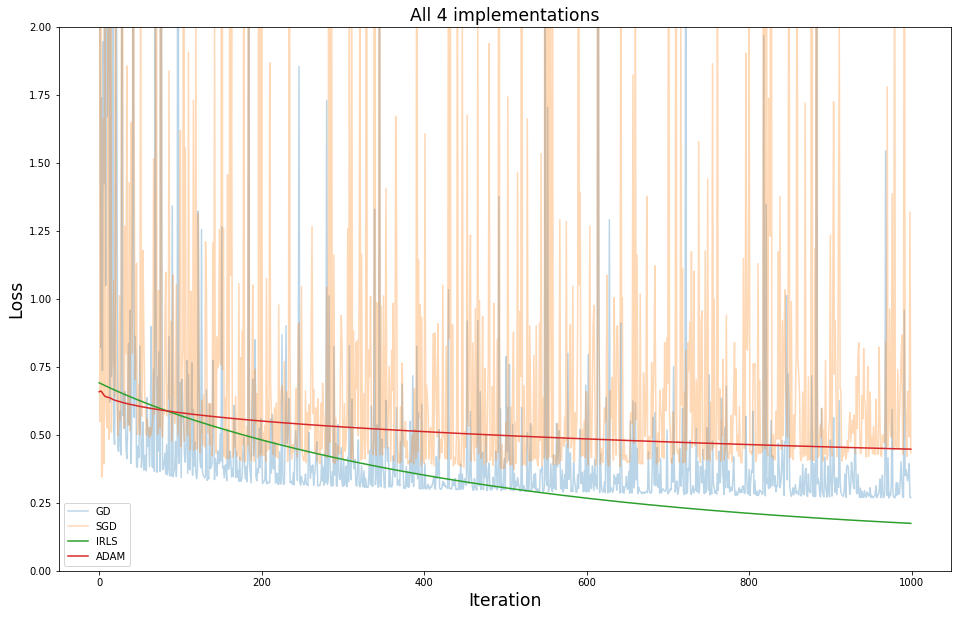

In [38]:
plt.figure(figsize=(16, 10))
for model_name, model in lr_models.items():
    alpha = 0.3 if 'GD' in model_name else 1.0
    plt.plot(range(len(losses[model_name])), losses[model_name], label=model_name, alpha=alpha)
plt.title('All 4 implementations',fontsize='xx-large')
plt.xlabel("Iteration",fontsize='xx-large')
plt.ylabel("Loss",fontsize='xx-large')
plt.legend()
plt.ylim((0, 2))
plt.savefig("wdbc_conv_02.svg")
plt.show()

#### 2. Check how the value of learning rate and other parameters affect the results.
The efficiency will be measured on the test dataset.

Checking various values of learning rates:

In [84]:
tested_l_rates=np.linspace(start=0.2,stop=1e-5,num=11)
tested_algorithms={'GD': 'Gradient Descent','SGD':'Stochastic Gradient Descent','ADAM':'Adaptive Moment Estimation'}
res_test_learning_rates_total=pd.DataFrame()
for i in range(20):
    res_test_learning_rates=experiments.test_learning_rates(X_train=X_train,
                                                        y_train=y_train,
                                                        X_test=X_test,
                                                        y_test=y_test,
                                                        l_rates=tested_l_rates,
                                                        algorithms=tested_algorithms,n_epochs=200)
    res_test_learning_rates_total=pd.concat([res_test_learning_rates_total,res_test_learning_rates],ignore_index=True)

In [124]:
res_test_learning_rates_total_mean = res_test_learning_rates_total.groupby(by=['method','learning_rate']).mean()

Top 2 scores for every algorithm:

In [130]:
res_test_learning_rates_total_mean.sort_values(['method', 'accuracy', 'F_measure'], ascending=[True, False, False])\
                                  .groupby('method').head(2)

accuracy  recall  precision  F_measure
method learning_rate                                        
ADAM   0.020009          0.909   0.792      0.955      0.866
       0.120004          0.895   0.736      0.975      0.839
GD     0.140003          0.902   0.811      0.915      0.860
       0.020009          0.902   0.774      0.953      0.854
SGD    0.080006          0.937   0.906      0.923      0.914
       0.100005          0.937   0.906      0.923      0.914

From the informations above (tested for n_epochs=100,175 and 250) we conclude that the best learning rates are:
- 0.02 for ADAM (its lr decreases a little with each epoch)
- 0.14 for GD (with batch size=32)
- 0.08 for SGD.

However, conducted experiments did not indicate any monotonic dependencies between learning rates and scores.

Testing ADAM's betas:, along with a few learning rates on fixed number of epochs:

In [47]:
tested_betas_1=np.linspace(start=0.75,stop=.97,num=12)
tested_betas_2=np.linspace(start=0.90,stop=0.99,num=10)
tested_lr_adam=[0.002, 0.02, 0.2]

res_test_betas=experiments.test_betas(X_train=X_train, 
                                      y_train=y_train,
                                      X_test=X_test,
                                      y_test=y_test,
                                      tested_betas1=tested_betas_1,
                                      tested_betas2=tested_betas_2,
                                      learning_rates=tested_lr_adam,
                                      n_epochs=50)

res_test_betas.sort_values(by=['accuracy','F_measure','recall','precision'],ascending=False).head(10)

,beta1,beta2,accuracy,recall,precision,F_measure,lr
320,0.91,0.90,0.909091,0.792453,0.954545,0.865979,0.20
321,0.91,0.91,0.909091,0.792453,0.954545,0.865979,0.20
318,0.89,0.98,0.909091,0.773585,0.976190,0.863158,0.20
319,0.89,0.99,0.909091,0.773585,0.976190,0.863158,0.20
323,0.91,0.93,0.909091,0.773585,0.976190,0.863158,0.20
327,0.91,0.97,0.909091,0.773585,0.976190,0.863158,0.20
328,0.91,0.98,0.909091,0.773585,0.976190,0.863158,0.20
210,0.93,0.90,0.902098,0.849057,0.882353,0.865385,0.02
211,0.93,0.91,0.902098,0.849057,0.882353,0.865385,0.02
238,0.97,0.98,0.902098,0.849057,0.882353,0.865385,0.02


The experiments (tested n_epochs=30, 40, 50, 75 ,100) above show that beta1 and beta2 parameters don't have a big incluence on the models performance. However always beta_1=0.91 was among the best results

#### 3. Compare the classification performance of logistic regression (try all 4 methods: IWLS, GD, SGD and ADAM) and 3 popular classification methods: LDA, QDA and KNN. Use the performance measures implemented in Part 2 and datasets prepared in Part 1. The performance measures should be calculated on test set. If the given algorithm does not converge, within 1000 iterations, stop the algorithm and use the solutions from the last iteration.

We'll use learning rates and other parameters which perfomed the best in the previous experiments

In [48]:
n_epochs=1000

batch_size_gd=32
lr_gd=0.14

lr_sgd=0.08

lr_adam=0.2
beta1_adam=0.91
beta2_adam=0.9

models = {
    'GD': LogReg(optimization='Gradient Descent',
                 learning_rate=lr_gd,
                 epochs=n_epochs,
                 batch_size=batch_size_gd),
    'SGD': LogReg(optimization='Stochastic Gradient Descent',
                  learning_rate=lr_sgd,
                  epochs=n_epochs),
    'IRLS': LogReg(optimization='Iterative Reweighted Least Squares',
                   epochs=n_epochs),
    'ADAM': LogReg(optimization='Adaptive Moment Estimation',
                   epochs=n_epochs,
                   learning_rate=lr_adam,
                   beta_1=beta1_adam,
                   beta_2=beta2_adam,
                   epsilon=1e-8),
    'LDA': LinearDiscriminantAnalysis(),
    'QDA': QuadraticDiscriminantAnalysis(),
    'LR': LogisticRegression(max_iter=n_epochs),
    'kNN': KNeighborsClassifier()
}

In [49]:
res_final=experiments.final_comparisson(X_train=X_train,
                                        y_train=y_train,
                                        X_test=X_test,
                                        y_test=y_test,
                                        models=models)

res_final.sort_values(by=['accuracy','f_measure','recall','precision'],ascending=False)

,model,accuracy,recall,precision,f_measure
5,QDA,0.944056,0.905660,0.941176,0.923077
2,IRLS,0.937063,0.849057,0.978261,0.909091
1,SGD,0.923077,0.867925,0.920000,0.893204
0,GD,0.923077,0.849057,0.937500,0.891089
3,ADAM,0.916084,0.849057,0.918367,0.882353
6,LR,0.916084,0.830189,0.936170,0.880000
7,kNN,0.909091,0.811321,0.934783,0.868687
4,LDA,0.874126,0.773585,0.872340,0.820000


As we can see for this dataset our results match expected ones. IRLS perfomed the best, followed by ADAM, SGD and GD whereas GD and SGD perfomances were very similar. Worth to note that QDA appeared to be the best approach while kNN and LDA perfomed pretty poorly.

#### 5. Comparing convergence analysis for the "best" parameters.

In [50]:
n_epochs=1000

batch_size_gd=32
lr_gd=0.14

lr_sgd=0.08

lr_adam=0.2
beta1_adam=0.91
beta2_adam=0.9

lr_models = {
     'GD': LogReg(optimization='Gradient Descent',
                 learning_rate=lr_gd,
                 epochs=n_epochs,
                 batch_size=batch_size_gd),
    'SGD': LogReg(optimization='Stochastic Gradient Descent',
                  learning_rate=lr_sgd,
                  epochs=n_epochs),
    'IRLS': LogReg(optimization='Iterative Reweighted Least Squares',
                   epochs=n_epochs),
    'ADAM': LogReg(optimization='Adaptive Moment Estimation',
                   epochs=n_epochs,
                   learning_rate=lr_adam,
                   beta_1=beta1_adam,
                   beta_2=beta2_adam,
                   epsilon=1e-8)
 }

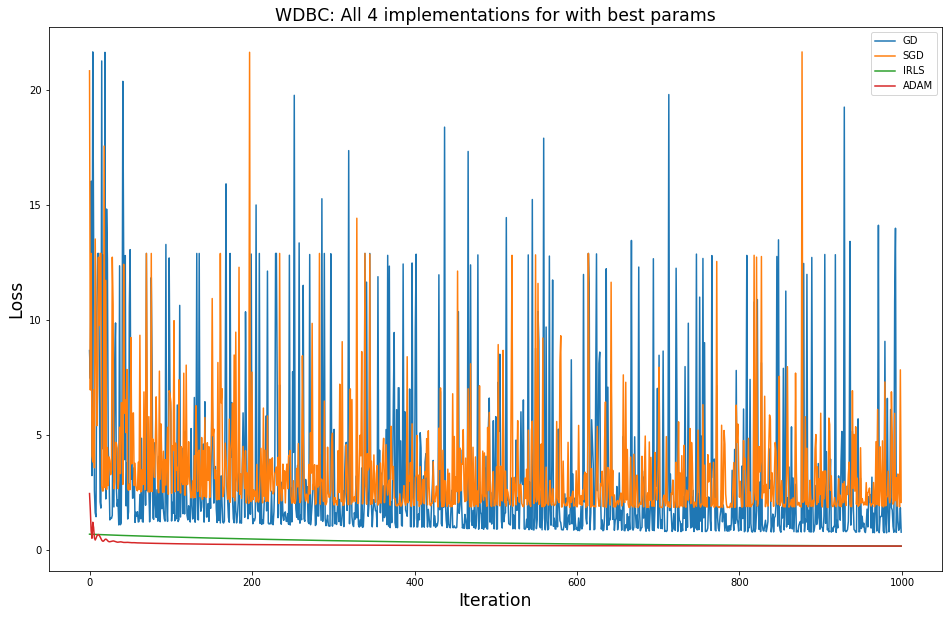

In [86]:
plt.figure(figsize=(16, 10))
# losses={}
for model_name, model in lr_models.items():
#     model.train(X_train, y_train)
#     losses[model_name]=model.get_optimizer_training_losses()
    plt.plot(range(len(losses[model_name])), losses[model_name], label=model_name)
plt.title('WDBC: All 4 implementations for with best params',fontsize='xx-large')
plt.xlabel("Iteration",fontsize='xx-large')
plt.ylabel("Loss",fontsize='xx-large')
plt.legend()
plt.savefig('wdbc_conv_03.svg')
plt.show()

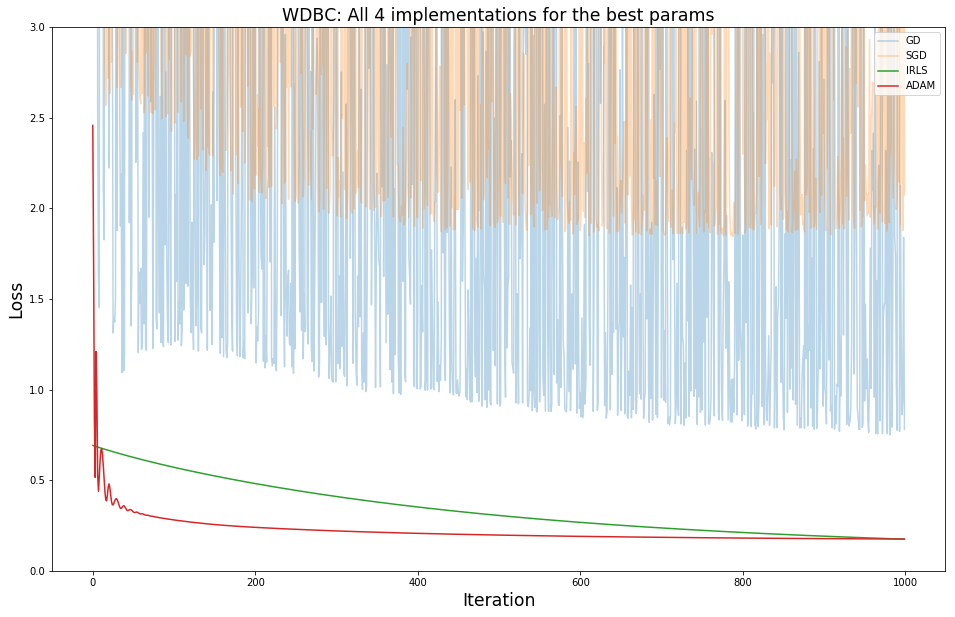

In [87]:
plt.figure(figsize=(16, 10))
# losses={}
for model_name, model in lr_models.items():
#     model.train(X_train, y_train)
#     losses[model_name]=model.get_optimizer_training_losses()
    a = 0.3 if 'GD' in model_name else 1.0
    plt.plot(range(len(losses[model_name])), losses[model_name], label=model_name, alpha = a)
plt.title('WDBC: All 4 implementations for the best params',fontsize='xx-large')
plt.xlabel("Iteration",fontsize='xx-large')
plt.ylabel("Loss",fontsize='xx-large')
plt.ylim(0, 3)
plt.legend()
plt.savefig('wdbc_conv_04.svg')
plt.show()

#### 6. Comparison of coefficients in different logistic regression algorithms:

In [74]:
lr_coefs = {alg: models[alg].get_optimizer_training_w().flatten() for alg in ['GD', 'SGD', 'IRLS', 'ADAM']}
lr_coefs['LR'] = np.concatenate((models['LR'].intercept_, models['LR'].coef_.flatten()))

In [76]:
pd.DataFrame(lr_coefs)

,GD,SGD,IRLS,ADAM,LR
0,-28.875364,-166.983020,-4.611362,-6.100458,-4.649405
1,-13.481966,-46.798184,0.318580,-0.795742,-0.982702
2,1.048542,4.747400,0.062540,0.126904,0.119277
3,-0.271787,-1.952422,106.142817,-11.141470,-0.027319
4,-0.637009,-27.633093,-37.220015,-8.274711,-0.461611
5,-1.101989,-11.329458,-32.070977,-11.272454,-0.152654
6,-0.238527,-4.128425,-140.630439,-11.027745,-0.064861
7,31.618365,232.005162,11.513966,10.259974,4.776841


The observation that different algorithms return different values of coefficients is quite interesting...